In [0]:
#configurar ambiente

spark.conf.set(
  "fs.azure.account.key.beeschallenge.dfs.core.windows.net",
  "AZURE_SECRET_KEY"
)

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:136)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:136)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:133)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:133)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:714)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:432)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:432)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

In [0]:
#declarar o df bronze para tratamento com os dados capturados da api

df_bronze = spark.read.json("abfss://bronze@beeschallenge.dfs.core.windows.net/brewery_usa_100.json")
df_bronze.display()

---------------------------------------------------------------------------
Py4JJavaError                             Traceback (most recent call last)
File <command-5597029085538378>, line 1
----> 1 df_bronze = spark.read.json("abfss://bronze@beeschallenge.dfs.core.windows.net/brewery_usa_100.json")
      2 df_bronze.display()

File /databricks/spark/python/pyspark/instrumentation_utils.py:47, in _wrap_function.<locals>.wrapper(*args, **kwargs)
     45 start = time.perf_counter()
     46 try:
---> 47     res = func(*args, **kwargs)
     48     logger.log_success(
     49         module_name, class_name, function_name, time.perf_counter() - start, signature
     50     )
     51     return res

File /databricks/spark/python/pyspark/sql/readwriter.py:469, in DataFrameReader.json(self, path, schema, primitivesAsString, prefersDecimal, allowComments, allowUnquotedFieldNames, allowSingleQuotes, allowNumericLeadingZero, allowBackslashEscapingAnyCharacter, mode, columnNameOfCorruptRecord, da

In [0]:
from pyspark.sql.functions import col, lower

# leitura da camada Bronze
df_bronze = spark.read.json("abfss://bronze@beeschallenge.dfs.core.windows.net/brewery_usa_100.json")

# transformações
df_silver = (
    df_bronze
    .filter(col("state").isNotNull())                      # Remove registros sem estado
    .withColumn("brewery_type", lower(col("brewery_type"))) # Padroniza brewery_type para lowercase
    .dropDuplicates()                                      # Remove duplicatas (opcional)
)

# caminho Silver
silver_path = "abfss://silver@beeschallenge.dfs.core.windows.net/brewery_silver"

# gravação particionada por estado em formato delta
df_silver.write.format("delta") \
    .mode("overwrite") \
    .partitionBy("state") \
    .save(silver_path)

In [0]:
silver_path = "abfss://silver@beeschallenge.dfs.core.windows.net/brewery_silver/"

df_silver = spark.read.format("delta").load(silver_path)
df_silver.show(5)

+-----------------+---------+---------+------------+------------+-------------+--------------------+-----------+------------+--------------------+----------+-----------+--------+--------------+-----------------+--------------------+
|        address_1|address_2|address_3|brewery_type|        city|      country|                  id|   latitude|   longitude|                name|     phone|postal_code|   state|state_province|           street|         website_url|
+-----------------+---------+---------+------------+------------+-------------+--------------------+-----------+------------+--------------------+----------+-----------+--------+--------------+-----------------+--------------------+
|  110 E Kansas St|     NULL|     NULL|     brewpub|     Liberty|United States|4f70ac94-eca5-4ce...| 39.2461993| -94.4190247|  3Halves Brewing Co|8164296886| 64068-2374|Missouri|      Missouri|  110 E Kansas St|http://www.3halve...|
|   111 N Main St |     NULL|     NULL|       micro|Independence|Uni

In [0]:
#camada gold com campos necessários para análise
from pyspark.sql.functions import count
df_gold = (

    df_silver
    .groupBy("name","brewery_type", "state", "city","latitude","longitude")
    .agg(count("*").alias("brewery_count"))
    .orderBy("state", "city", "brewery_type")
)

# mostrar resultado
df_gold.show(truncate=False)

+---------------------------------------------+------------+----------+----------------+-----------+------------+-------------+
|name                                         |brewery_type|state     |city            |latitude   |longitude   |brewery_count|
+---------------------------------------------+------------+----------+----------------+-----------+------------+-------------+
|12 West Brewing Company                      |micro       |Arizona   |Gilbert         |NULL       |NULL        |1            |
|12 West Brewing Company - Production Facility|micro       |Arizona   |Mesa            |33.436188  |-111.5860662|1            |
|1912 Brewing                                 |micro       |Arizona   |Tucson          |32.24673727|-110.9927505|1            |
|3 Iron Brewing Company                       |micro       |California|Colton          |34.05616889|-117.3066993|1            |
|1850 Brewing Company                         |micro       |California|Mariposa        |37.570148  |-119

In [0]:
gold_path = "abfss://gold@beeschallenge.dfs.core.windows.net/brewery_gold_delta"

df_gold.write.format("delta").mode("overwrite").save(gold_path)

In [0]:
display(df_gold)

name,brewery_type,state,city,latitude,longitude,brewery_count
12 West Brewing Company,micro,Arizona,Gilbert,null,null,1
12 West Brewing Company - Production Facility,micro,Arizona,Mesa,33.436188,-111.5860662,1
1912 Brewing,micro,Arizona,Tucson,32.24673727,-110.9927505,1
3 Iron Brewing Company,micro,California,Colton,34.05616889,-117.3066993,1
1850 Brewing Company,micro,California,Mariposa,37.570148,-119.9036592,1
101 North Brewing Company,closed,California,Petaluma,38.27029381,-122.665055,1
32 North Brewing Co,brewpub,California,San Diego,32.88313237,-117.1649842,1
10 Barrel Brewing Co,large,California,San Diego,32.714813,-117.129593,1
2Kids Brewing Company,micro,California,San Diego,32.896584,-117.137429,1
21st Amendment Brewery Cafe,brewpub,California,San Francisco,37.782448,-122.3925769,1


In [0]:
brewerysum = df_gold.groupBy("brewery_type").sum("brewery_count").orderBy("sum(brewery_count)", ascending=False)
display(brewerysum)

brewery_type,sum(brewery_count)
micro,56
brewpub,25
large,7
closed,4
contract,3
proprietor,2
planning,2
regional,1


In [0]:
import matplotlib.pyplot as plt

# converte o df Spark para Pandas
brewerysum_pd = brewerysum.toPandas()

# cria o gráfico
plt.figure(figsize=(12,6))
plt.bar(brewerysum_pd['brewery_type'], brewerysum_pd['sum(brewery_count)'], color='skyblue')
plt.xticks(rotation=45)
plt.xlabel('Tipo de Cervejaria')
plt.ylabel('Quantidade Total de Cervejarias')
plt.title('Total de Cervejarias por Tipo')
plt.tight_layout()
plt.show()

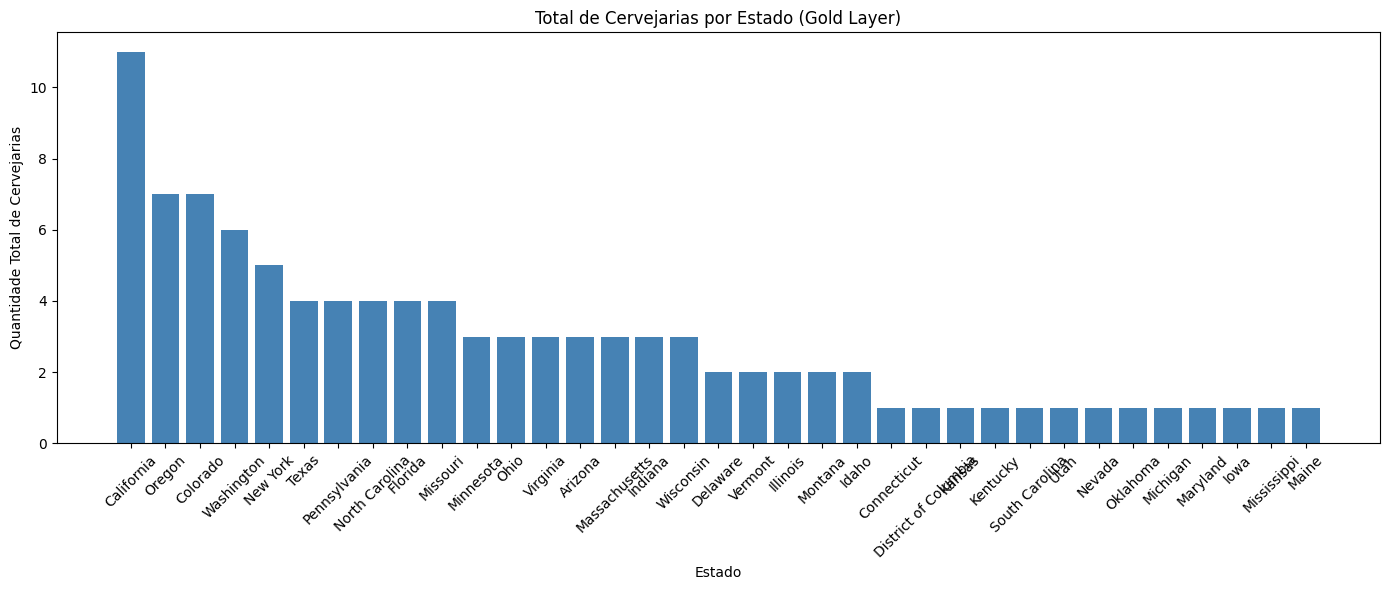

In [0]:
# agrupa por estado e soma o total de cervejarias
state_sum = df_gold.groupBy("state").sum("brewery_count").orderBy("sum(brewery_count)", ascending=False)

# converte para Pandas
state_sum_pd = state_sum.toPandas()

# cria o gráfico
plt.figure(figsize=(14,6))
plt.bar(state_sum_pd['state'], state_sum_pd['sum(brewery_count)'], color='steelblue')
plt.xticks(rotation=45)
plt.xlabel('Estado')
plt.ylabel('Quantidade Total de Cervejarias')
plt.title('Total de Cervejarias por Estado')
plt.tight_layout()
plt.show()

In [0]:
import json
import requests

# Baixar o GeoJSON dos estados dos EUA
url = 'https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json'
response = requests.get(url)
us_states_geojson = response.json()

In [0]:
state_sum = df_gold.groupBy("state").sum("brewery_count").withColumnRenamed("sum(brewery_count)", "brewery_count")
state_sum_pd = state_sum.toPandas()

In [0]:
import plotly.express as px

fig = px.choropleth(
    state_sum_pd,
    geojson=us_states_geojson,
    locations="state",
    featureidkey="properties.name",
    color="brewery_count",
    color_continuous_scale="Viridis",
    scope="usa",
    title="Quantidade de Cervejarias por Estado"
)

fig.update_geos(fitbounds="locations", visible=False)
fig.show()

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-6266875200308400>, line 4
      1 import plotly.express as px
      3 fig = px.choropleth(
----> 4     state_sum_pd,
      5     geojson=us_states_geojson,
      6     locations="state",
      7     featureidkey="properties.name",
      8     color="brewery_count",
      9     color_continuous_scale="Viridis",
     10     scope="usa",
     11     title="Quantidade de Cervejarias por Estado"
     12 )
     14 fig.update_geos(fitbounds="locations", visible=False)
     15 fig.show()

NameError: name 'state_sum_pd' is not defined